## 1. Import Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os, shutil
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## 2. Load Dataset dan Split

In [3]:
# 1. SETUP PATH DAN PARAMETER
source_dir = "/content/drive/MyDrive/Alzheimers_Detection_dataset"
base_dir = "/content/dataset_split"
os.makedirs(base_dir, exist_ok=True)
split_ratio = [0.7, 0.15, 0.15]  # Train, Val, Test

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

if not os.path.exists(train_dir):
    from tqdm import tqdm

    # Ensure base directories exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    successful_train_classes = []

    for class_name in tqdm(os.listdir(source_dir)):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        n_samples = len(images)

        # Calculate the number of samples for each split
        n_train = int(n_samples * split_ratio[0])
        n_val = int(n_samples * split_ratio[1])
        n_test = n_samples - n_train - n_val

        # Skip classes with insufficient images for splitting into non-empty sets
        if n_train == 0 or n_val == 0 or n_test == 0:
            print(f"Skipping class '{class_name}' due to insufficient images ({len(images)}) for splitting with the current ratio.")
            continue

        # If a class has enough images, split and copy them
        train_files, temp_files = train_test_split(images, train_size=n_train, test_size=(n_val + n_test), random_state=42)
        val_files, test_files = train_test_split(temp_files, train_size=n_val, test_size=n_test, random_state=42)

        # Create class directories in each split and copy files
        for split, file_list in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
            split_class_dir = os.path.join(base_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for file in file_list:
                shutil.copy(os.path.join(class_path, file), os.path.join(split_class_dir, file))

        # Add the class to the list of successful training classes
        successful_train_classes.append(class_name)

    # Clean up directories for classes that didn't make it into training
    for split_dir in [val_dir, test_dir]:
        for class_name in os.listdir(split_dir):
            if class_name not in successful_train_classes:
                class_to_remove = os.path.join(split_dir, class_name)
                shutil.rmtree(class_to_remove)
                print(f"Removed class '{class_name}' from {split_dir} as it was not in the training set.")

# DATA GENERATORS DENGAN AUGMENTASI

In [4]:
# 3. DATA GENERATORS DENGAN AUGMENTASI
img_width, img_height = 224, 224
0
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Get the list of class names from the training directory after splitting
train_classes = sorted(os.listdir(os.path.join(base_dir, "train")))

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    classes=train_classes # Explicitly set classes
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    classes=train_classes, # Explicitly set classes
    shuffle=False # Keep order for evaluation consistency with test set
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    classes=train_classes, # Explicitly set classes
    shuffle=False  # Keep data in order for evaluation
)

Found 988 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


## 3. Build Model CNN

In [5]:
# 4. BUILD MODEL CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 4. Compile dan Train Model

In [6]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

# Latih model selama 30 epoch
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step - accuracy: 0.7073 - loss: 2.4840 - val_accuracy: 1.0000 - val_loss: 0.2012 - learning_rate: 0.0010
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.9023 - loss: 0.3394 - val_accuracy: 1.0000 - val_loss: 0.0501 - learning_rate: 0.0010
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.9229 - loss: 0.2766 - val_accuracy: 1.0000 - val_loss: 0.0401 - learning_rate: 0.0010
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.9133 - loss: 0.3143 - val_accuracy: 1.0000 - val_loss: 0.0673 - learning_rate: 0.0010
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.9104 - loss: 0.3069 - val_accuracy: 1.0000 - val_loss: 0.1115 - learning_rate: 0.0010
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9000 - loss: 0.3412
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
31/31 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.9002 - loss: 0.3408 - val_accura

## 5. Plot Akurasi dan Loss

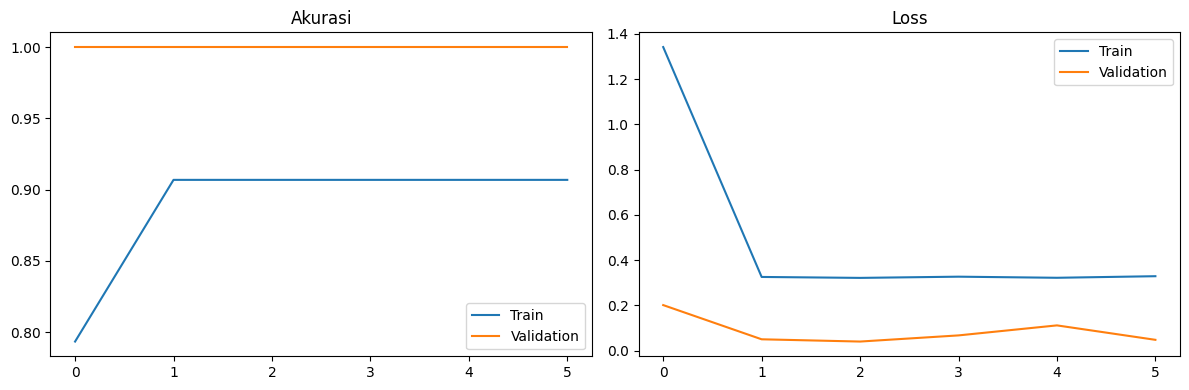

In [7]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# EVALUASI

In [8]:
print("\nEvaluasi pada Training Set:")
model.evaluate(train_generator)

print("\nEvaluasi pada Testing Set:")
model.evaluate(test_generator)


Evaluasi pada Training Set:
31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9060 - loss: 0.3444

Evaluasi pada Testing Set:
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 651ms/step - accuracy: 1.0000 - loss: 0.2003


[0.20158709585666656, 1.0]

## 6. Simpan Model ke SavedModel, TFLite, TFJS

In [9]:
# SavedModel format
model.export("submission/saved_model")

# TF Lite format
converter = tf.lite.TFLiteConverter.from_saved_model("submission/saved_model")
tflite_model = converter.convert()
os.makedirs("submission/tflite", exist_ok=True)
with open("submission/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan label.txt
labels = list(train_generator.class_indices.keys())
with open("submission/tflite/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\\n")


Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134241046125008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134241046125776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134241046128080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134241046125392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134241046127504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134241046129808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134241046129616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134241046130000: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [10]:

# TensorFlow.js format
!pip install tensorflowjs
!mkdir -p submission/tfjs_model
!tensorflowjs_converter --input_format=tf_saved_model submission/saved_model submission/tfjs_model


2025-07-04 04:36:42.173154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751603802.215809   15407 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751603802.228297   15407 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-07-04 04:36:48.384060: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1751603809.107690   15407 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

## 7. Simpan requirements.txt dan README.md

In [11]:

!pip freeze > submission/requirements.txt

with open("submission/README.md", "w") as f:
    f.write("# Image Classification Submission\n\nThis project classifies dog breeds using a CNN model built with TensorFlow/Keras.\n")


In [12]:

!zip -r submission.zip submission


  adding: submission/ (stored 0%)
  adding: submission/tfjs_model/ (stored 0%)
  adding: submission/tfjs_model/group1-shard14of46.bin (deflated 7%)
  adding: submission/tfjs_model/group1-shard27of46.bin (deflated 7%)
  adding: submission/tfjs_model/group1-shard2of46.bin (deflated 8%)
  adding: submission/tfjs_model/group1-shard28of46.bin (deflated 8%)
  adding: submission/tfjs_model/group1-shard34of46.bin (deflated 7%)
  adding: submission/tfjs_model/group1-shard25of46.bin (deflated 8%)
  adding: submission/tfjs_model/group1-shard26of46.bin (deflated 8%)
  adding: submission/tfjs_model/group1-shard44of46.bin (deflated 8%)
  adding: submission/tfjs_model/group1-shard18of46.bin (deflated 8%)
  adding: submission/tfjs_model/group1-shard5of46.bin (deflated 8%)
  adding: submission/tfjs_model/group1-shard40of46.bin (deflated 7%)
  adding: submission/tfjs_model/group1-shard29of46.bin (deflated 7%)
  adding: submission/tfjs_model/group1-shard8of46.bin (deflated 8%)
  adding: submission/tfjs_m